# Betweenness Test
Notebook used to test distributed implementation of betweenness

In [1]:
### Initialisation

In [2]:
from pyspark.sql import SparkSession
import os
import sys

SPARK_HOME="/home/human/l/rh/platform/spark-2.3.0-bin-hadoop2.7"
DATA = "data/"
OUTPUT = DATA + "out/"

## SparkSession is one main connection with the Spark driver
session = SparkSession \
    .builder \
    .appName("Distributed-Community-Scanner") \
    .config("spark.sql.autoBroadcastJoinThreshold", '-1') \
    .config("spark.ui.enabled", 'true')\
    .getOrCreate()

sc = session.sparkContext

In [3]:
# Add the parent project to the syspath to be able to import the modules
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Import modules
from inout.parser import parse
from inout.parser import get_headers
from view.visualiser import draw
from algorithms.shortest_path import single_source_shortest_paths_dijkstra
from distributed_algorithms.betweenness import compute_edge_betweenness

In [4]:
# edges_file = 'edges.csv'
edges_limit = 100  # maximum numbers of edges to be parsed.
edges_file = 'girvan_graph.csv'
edges_path = os.path.join(DATA, edges_file)
headers = get_headers(edges_path)
source_header, target_header, weight_header = headers

# Parse with edges limit:
# graph = parse(edges_path, edge_limit=edges_limit, 
#               source_header=source_header, target_header=target_header, weight_header=weight_header)

# Parse the entire graph (no 'edge_limit' parameter):
graph_driver = parse(edges_path,  # edge_limit=edges_limit, 
              source_header=source_header, target_header=target_header, weight_header=weight_header)

len(list(graph_driver.edges))

38

/home/human/l/_PGR_NCL/BigData/dev/community_scanner/venv/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


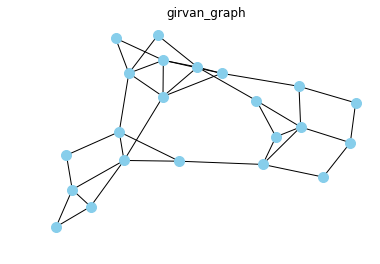

In [5]:
draw(graph_driver)

### Broadcast Graph and Algorithms to Workers

In [6]:
# Add dependencies to workers
dependencies_path = "community_scanner.zip"
sc.addPyFile(dependencies_path)

In [7]:
graphBC = sc.broadcast(graph_driver)

In [8]:
def sssp(source):
    """
    Single-Source Shortest path function for the Spark workers.
    Prerrequisite: the 'algorithms' module needs to be added as dependency to all workers with sc.addPyFile  
    :param source: 
    :return: 
    """
    from algorithms.shortest_path import single_source_shortest_paths_dijkstra
    paths, distances = single_source_shortest_paths_dijkstra(graphBC.value, source=source)
    return (source, paths)

### Parallelise node IDs into RDDs

In [9]:
nodes_rdd = sc.parallelize(graph_driver.nodes) 
nodes_rdd.take(5)

[1, 6, 8, 2, 3]

In [10]:
nodes_rdd.getNumPartitions()

8

In [11]:
# Get number of elements in each partition
nodes_rdd.glom().map(len).collect()

[2, 2, 4, 2, 2, 4, 2, 4]

### Compute shortests paths in workers

In [12]:
# shortest_paths_rdd := [(source, paths)]
# paths := {target: [shortest_path]}
# shortest_path := [node]

shortest_paths_rdd = nodes_rdd.map(sssp)
shortest_paths_rdd.cache()
shortest_paths_rdd.take(1)

[(1,
  {1: [[1]],
   2: [[1, 6, 2], [1, 8, 2]],
   3: [[1, 6, 2, 3], [1, 8, 2, 3], [1, 6, 4, 3]],
   4: [[1, 6, 4]],
   5: [[1, 6, 2, 5], [1, 8, 2, 5], [1, 8, 7, 5]],
   6: [[1, 6]],
   7: [[1, 8, 7]],
   8: [[1, 8]],
   9: [[1, 6, 12, 10, 9]],
   10: [[1, 6, 12, 10]],
   11: [[1, 6, 12, 15, 11]],
   12: [[1, 6, 12]],
   13: [[1, 6, 12, 15, 11, 13], [1, 6, 12, 15, 14, 13]],
   14: [[1, 6, 12, 15, 14]],
   15: [[1, 6, 12, 15]],
   16: [[1, 6, 12, 15, 16]],
   17: [[1, 6, 2, 3, 21, 17],
    [1, 8, 2, 3, 21, 17],
    [1, 6, 4, 3, 21, 17],
    [1, 6, 2, 5, 22, 17],
    [1, 8, 2, 5, 22, 17],
    [1, 8, 7, 5, 22, 17],
    [1, 6, 12, 10, 18, 17],
    [1, 6, 12, 15, 16, 17]],
   18: [[1, 6, 12, 10, 18]],
   19: [[1, 6, 2, 3, 21, 19],
    [1, 8, 2, 3, 21, 19],
    [1, 6, 4, 3, 21, 19],
    [1, 6, 12, 10, 18, 19]],
   20: [[1, 6, 12, 10, 18, 20]],
   21: [[1, 6, 2, 3, 21], [1, 8, 2, 3, 21], [1, 6, 4, 3, 21]],
   22: [[1, 6, 2, 5, 22], [1, 8, 2, 5, 22], [1, 8, 7, 5, 22]]})]

### Compute Betweeness

In [13]:
edge_betweenness_rdd = compute_edge_betweenness(shortest_paths_rdd)
edge_betweenness_rdd.cache()
edge_betweenness_rdd.collect()

[((2, 8), 69.9047619047619),
 ((6, 12), 191.4793650793651),
 ((11, 15), 106.36190476190477),
 ((5, 22), 135.8968253968254),
 ((13, 14), 45.63809523809524),
 ((21, 22), 30.0),
 ((5, 7), 74.24603174603175),
 ((2, 5), 65.06031746031745),
 ((4, 6), 50.53809523809524),
 ((9, 14), 27.685714285714287),
 ((17, 22), 48.560317460317464),
 ((14, 15), 108.1047619047619),
 ((1, 6), 83.84920634920634),
 ((2, 3), 63.03809523809524),
 ((16, 21), 70.36825396825398),
 ((18, 19), 45.33968253968254),
 ((11, 14), 8.0),
 ((16, 22), 89.33650793650793),
 ((17, 21), 43.58253968253968),
 ((16, 17), 30.109523809523807),
 ((9, 10), 73.53333333333335),
 ((17, 18), 38.042857142857144),
 ((10, 15), 42.96190476190476),
 ((2, 6), 90.22539682539684),
 ((12, 15), 119.3),
 ((1, 8), 40.84920634920635),
 ((16, 18), 48.62857142857142),
 ((2, 4), 18.0),
 ((18, 20), 41.19047619047619),
 ((10, 12), 92.17936507936507),
 ((3, 4), 42.53809523809524),
 ((15, 16), 178.29047619047617),
 ((7, 8), 33.86507936507936),
 ((11, 13), 38.36

In [14]:
assert edge_betweenness_rdd.count() == len(list(graph_driver.edges))

In [17]:
edge_with_highest_betweenness = \
    edge_betweenness_rdd.max(lambda row: row[1])[0]

edge_with_highest_betweenness

(6, 12)